# Exploring the Ames, Iowa Dataset via Kaggle.com

## Libraries

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import sklearn as skl
import statsmodels.api as sm
import re
from scipy.stats import norm

## Global Parameters

In [22]:
%matplotlib inline
sns.set()
warnings.filterwarnings('ignore')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (10,6)

## Reading in the Training and Test Data

In [23]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
data = pd.concat([train, test], axis = 0)

## Exploratory Data Analysis

### Data Frame Dimensions

In [24]:
train.shape

(1460, 81)

### Column Names

In [25]:
{'feature_names': train.columns}

{'feature_names': Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
        'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
        'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
        'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
        'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
        'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
        'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
        'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
        'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
        'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
        'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
        'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
        'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
  

### Ensure the only missing column from the test set is the target variable

In [26]:
list(set(train) - set(test))

['SalePrice']

### Just for preference, we will work with lowercase column names

In [27]:
#warning: the haters might hate this step
train.columns = [x.lower() for x in train.columns]
test.columns = [x.lower() for x in test.columns]

### Exploring the target Variable: *Home Purchase Price* (*`saleprice`*)

In [28]:
train.saleprice.describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: saleprice, dtype: float64

#### Comparing variable's distance from a Gaussian Distribution

Text(0.5, 1.0, 'Distribution of Home Purchase Price')

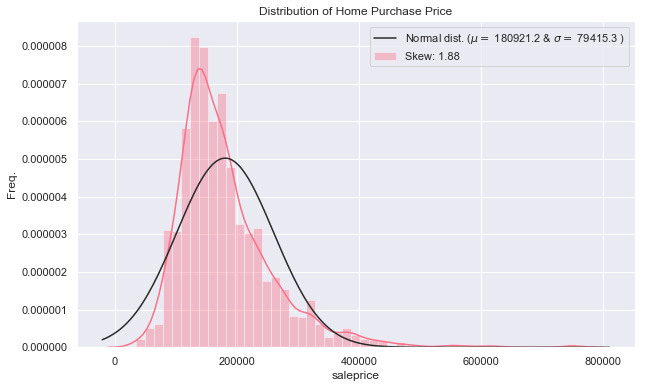

In [29]:
# Plot the distribution
sns.distplot(train['saleprice'] , fit=norm)

# Fit parameters
(mu, sigma) = norm.fit(train['saleprice'])

#Replot
plt.legend(['Normal dist. ($\mu=$ {:.1f} & $\sigma=$ {:.1f} )'.format(mu, sigma), 'Skew: {:.2f}'.format(train.saleprice.skew())],
            loc='best')
plt.ylabel('Freq.')
plt.title('Distribution of Home Purchase Price')

#### Let's explore logarithim of `saleprice`

Text(0.5, 1.0, 'Distribution of Home Purchase Price')

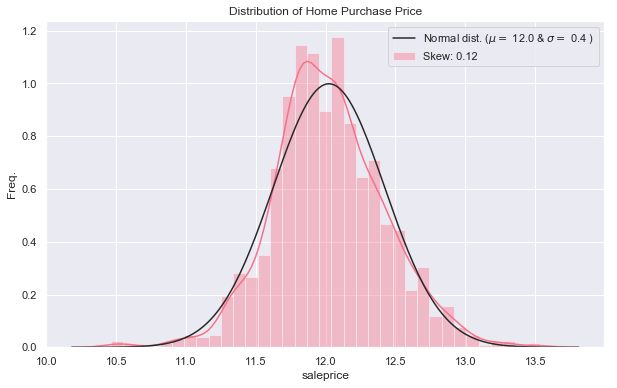

In [30]:
# Plot the distribution
log_price = np.log(train['saleprice'])
sns.distplot(log_price , fit=norm)

# Fit parameters
(mu, sigma) = norm.fit(log_price)

#Replot
plt.legend(['Normal dist. ($\mu=$ {:.1f} & $\sigma=$ {:.1f} )'.format(mu, sigma), 'Skew: {:.2f}'.format(log_price.skew())],
            loc='best')
plt.ylabel('Freq.')
plt.title('Distribution of Home Purchase Price')

It appears `log_saleprice` is approximately normal, with a skew an order of magnitude closer to $0$  compared to `saleprice`. We need to ensure normality in order accept any linear models' findings as valid. Therefore, we'll use `log_saleprice` as our target variable.

In [31]:
train['log_price'] = np.log(train.saleprice)
train.head(1)

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,...,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice,log_price
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,NaN,0,2,2008,WD,Normal,208500,12.247694


### Exploring Features

###### We'll first create a function `explore_variables()` that graphs numerical cols as scatter plots in relation to our target variables, and categoricals as swarmplots (scatter + boxplot).

In [32]:
def explore_variables(target_name, dt):
    for col in dt.drop(target_name, 1).columns:
        if train.dtypes[train.columns.get_loc(col)] == 'O': # categorical variable
            f, ax = plt.subplots()
            fig = sns.boxplot(x=col, y=target_name, data=dt)
            ax = sns.swarmplot(x=col, y=target_name, data=dt, color=".25", alpha=0.2)
            #max_trg = max(target_name)
            #fig.axis(ymin=0)
        else: # numerical variable
            fig, ax = plt.subplots()
            ax.scatter(x=dt[col], y=dt[target_name])
            plt.ylabel(target_name, fontsize=13)
            plt.xlabel(col, fontsize=13, rotation = 45)
            plt.show()

##### Exploring Visually

In [33]:
#explore_variables('saleprice', train)

## Feature Selection

### Removing the `id` variable
This is a unique number given to each house and is not relavent for prediction purposes.

In [34]:
train.drop('id', axis = 1, inplace = True)

### Null Values


##### Let's first create a series of functions to check on our dataset's `NULL` values:

In [35]:
def get_nulls(df):
    nulls = pd.DataFrame(df.isnull().sum().sort_values(ascending=False))[df.isnull().sum().sort_values() > 0]
    nulls.columns = ['Null Count']
    nulls['Null Pct'] = round(nulls['Null Count']/df.shape[0],4)
    nulls.index.name = 'Feature'
    return(nulls)

def get_null_colct(df):
    nulls = pd.DataFrame(df.isnull().sum().sort_values(ascending=False))[df.isnull().sum().sort_values() > 0]
    nulls.columns = ['Null Count']
    nulls['Null Pct'] = round(nulls['Null Count']/df.shape[0],4)
    nulls.index.name = 'Feature'
    return(len(nulls))

def get_null_colnames(df):
    nulls = pd.DataFrame(df.isnull().sum().sort_values(ascending=False))[df.isnull().sum().sort_values() > 0]
    nulls.columns = ['Null Count']
    nulls['Null Pct'] = round(nulls['Null Count']/df.shape[0],4)
    nulls.index.name = 'Feature'
    return(list(nulls.index))

##### First Check of `NULL` Values

In [36]:
get_nulls(train)

,Null Count,Null Pct
Feature,,
poolqc,1453,0.9952
miscfeature,1406,0.9630
alley,1369,0.9377
fence,1179,0.8075
fireplacequ,690,0.4726
lotfrontage,259,0.1774
garageyrblt,81,0.0555
garagetype,81,0.0555
garagequal,81,0.0555


##### The first five columns, Pool Quality (`poolqc`),  Misc. Feature (`miscfeature`), Alley Pavement Type (`alley`), Fence Type (`fence`), and Fireplace Quality (`fireplacequ`) stand out as removable features. For all five variables, 47% or more of the data contains `NaN` for these variables.






###### Let's attempt to ensure this information is encoded into our dataset in a more efficient manner:

##### Pool Quality (`poolqc`)

In [37]:
train.poolqc.value_counts()

Gd    3
Ex    2
Fa    2
Name: poolqc, dtype: int64

###### Only $7$ of $1460$ $($0.48%) of observations include non-`NA` values for this variable. Let's instead deliniate whether a home has a pool on the lot or not.

In [38]:
def _encode(x): return 1 if x > 0 else 0
train['enc_pool'] = train.poolarea.apply(_encode)
test['enc_pool'] = train.poolarea.apply(_encode)

###### Now `enc_pool` marks $1$ if a pool is present at the house, $0$ if not. It's now safe to drop the two other pool variables, **Pool Quality** (`poolqc`) and **Pool Area Sq. Footage** (`poolarea`)

In [39]:
train.drop(['poolqc', 'poolarea'], axis = 1, inplace = True)
test.drop(['poolqc', 'poolarea'], axis = 1, inplace = True)

##### Miscellaneous Feature (`miscfeature`) 







######  `miscfeature` has a related column, Misc. Feature Value (`miscval`) that is $0$ when the property does not include a Misc. Feature.

In [40]:
train.drop(['miscfeature'], axis = 1, inplace = True)
test.drop(['miscfeature'], axis = 1, inplace = True)

In [41]:
get_nulls(train)

,Null Count,Null Pct
Feature,,
alley,1369,0.9377
fence,1179,0.8075
fireplacequ,690,0.4726
lotfrontage,259,0.1774
garagetype,81,0.0555
garagecond,81,0.0555
garageyrblt,81,0.0555
garagefinish,81,0.0555
garagequal,81,0.0555


##### Alley Pavement Type (`alley`)





######  Next we can change `alley` to binary variable. $1$ if an alley of any pavement is present on the property, regardless of pavement type, and $0$ if no alley is on the property.

In [42]:
def _encode(x): return 0 if pd.isna(x) else 1
train['enc_alley'] = train.alley.apply(_encode)
test['enc_alley'] = train.alley.apply(_encode)

In [43]:
train.drop(['alley'], axis = 1, inplace = True)
test.drop(['alley'], axis = 1, inplace = True)

In [44]:
get_nulls(train)

,Null Count,Null Pct
Feature,,
fence,1179,0.8075
fireplacequ,690,0.4726
lotfrontage,259,0.1774
garageyrblt,81,0.0555
garagetype,81,0.0555
garagefinish,81,0.0555
garagequal,81,0.0555
garagecond,81,0.0555
bsmtexposure,38,0.0260


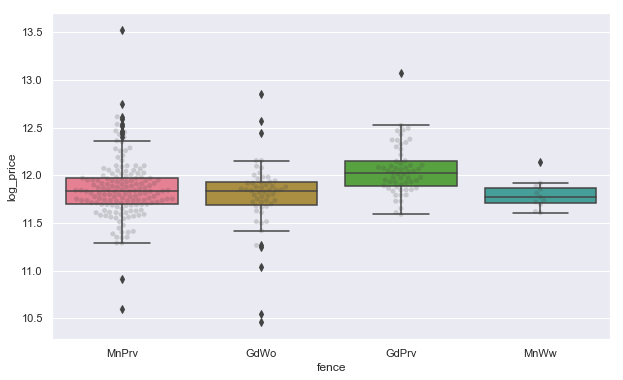

In [45]:
explore_variables('log_price', train.loc[:,['fence','log_price']])


###### It does not appear that any particular fencing type has a drastic effect on the logirithm of purchase price of a home, `log_price`. We can encode a dummy variable to deliniate homes that have a fence on the property from those that do not.

In [46]:
def _encode(x): return 0 if pd.isna(x) else 1
train['enc_fence'] = train.fence.apply(_encode)
test['enc_fence'] = train.fence.apply(_encode)

In [ ]:
train.drop(['fence'], axis = 1, inplace = True)
test.drop(['fence'], axis = 1, inplace = True)

### Fireplace Quality (`fireplacequ`)




In [63]:
get_nulls(train)

,Null Count,Null Pct
Feature,,
lotfrontage,259,0.1774
garageyrblt,81,0.0555
garagecond,81,0.0555
garagefinish,81,0.0555
garagequal,81,0.0555
garagetype,81,0.0555
bsmtfintype2,38,0.0260
bsmtexposure,38,0.0260
bsmtfintype1,37,0.0253


###### Fireplace Quality variable is an interesting set of `NA` values to handle. The only `NA` values are homes that do not include a fireplace at all, but our dataset already includes a *Number of Fireplaces* variable, `fireplaces`. 

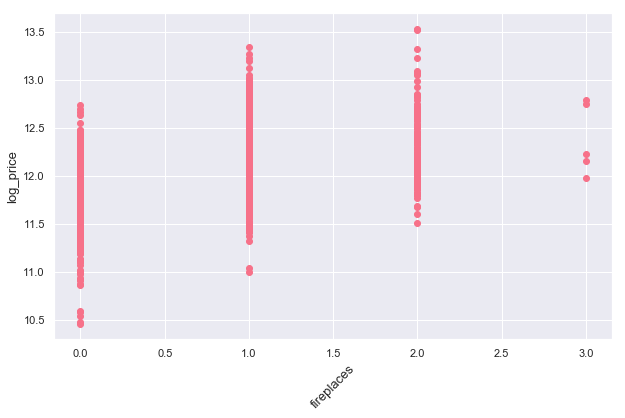

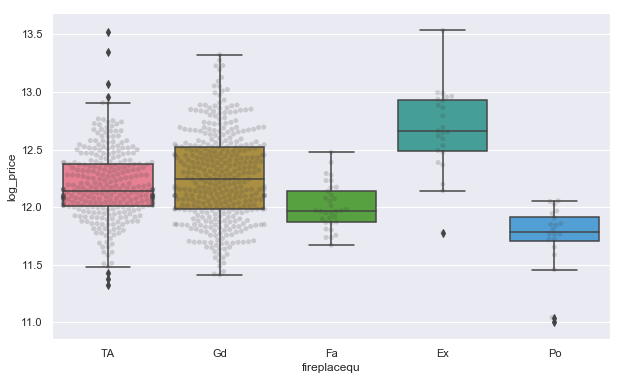

In [57]:
var = train.loc[:,['fireplaces','fireplacequ', 'log_price']]
explore_variables('log_price',  var)

While it's likely safe to drop the *Fireplace Quality* Metric due to many overlapping interquartile ranges, we'll choose to encode homes that do not include Fireplaces as a new `None` category. We'll dummify this variable prior to fitting any models.

In [60]:
def _encode(x): return 'None' if pd.isna(x) else x
train['fireplacequ'] = train.fireplacequ.apply(_encode)
test['fireplacequ'] = train.fireplacequ.apply(_encode)

###### Quickly exporing the new `fireplacequ` variable

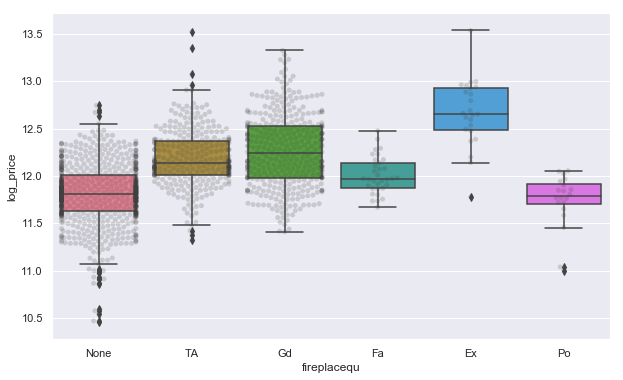

In [62]:
var = train.loc[:,['fireplacequ', 'log_price']]
explore_variables('log_price',  var)

In [65]:
get_nulls(train)

,Null Count,Null Pct
Feature,,
lotfrontage,259,0.1774
garageyrblt,81,0.0555
garagecond,81,0.0555
garagefinish,81,0.0555
garagequal,81,0.0555
garagetype,81,0.0555
bsmtfintype2,38,0.0260
bsmtexposure,38,0.0260
bsmtfintype1,37,0.0253


### Handling the `lotfrontage` Variable

`lotfrontage` is the linear feet of street connected to the property, we can encode all `NA` values as $0$

In [66]:
def _encode(x): return 0 if pd.isna(x) else x
train['lotfrontage'] = train.lotfrontage.apply(_encode)
test['lotfrontage'] = train.lotfrontage.apply(_encode)

In [67]:
get_nulls(train)

,Null Count,Null Pct
Feature,,
garageyrblt,81,0.0555
garagecond,81,0.0555
garagefinish,81,0.0555
garagequal,81,0.0555
garagetype,81,0.0555
bsmtfintype2,38,0.0260
bsmtexposure,38,0.0260
bsmtfintype1,37,0.0253
bsmtcond,37,0.0253


### Year Garage was Built (`garageyrblt`)

###### `garageyrbuilt` appears to be it's own column because there are cases where the age of the garage is different from *both* the original building date (`yearbuilt`) and the remodelling date (`yearrmodadd`), if that has ocurred.



$127$ Homes ($8.69$%) in our training set have a Garage Built after the latest home re-model:

In [94]:
train[(train.garageyrblt > train.yearremodadd) & (train.garageyrblt > train.yearbuilt) &
      (pd.isna(train.garageyrblt)==False)][['garageyrblt','yearbuilt','yearremodadd']].shape[0]

127

$9$ Homes ($0.61$%) in our training set have a Garage Built *before the listed building date of the home* as well as the latest home re-model:

In [95]:
train[(train.garageyrblt < train.yearremodadd) & (train.garageyrblt < train.yearbuilt) &
      (pd.isna(train.garageyrblt)==False)][['garageyrblt','yearbuilt','yearremodadd']]

,garageyrblt,yearbuilt,yearremodadd
29,1920.0,1927,1950
93,1900.0,1910,1998
324,1961.0,1967,2007
600,2003.0,2005,2005
736,1949.0,1950,1950
1103,1954.0,1959,1959
1376,1925.0,1930,1950
1414,1922.0,1923,2000
1418,1962.0,1963,1963


In [ ]:
train.gargeyrblt = if pd.isna(train.garageyrblt):
    train.yearremodadd else: train.garageyrblt

We'll encode two new dummy variables, `newgarage` for homes with a garage newer than the latest remodel, and `oldgarage` for homes with a garage 